# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-I,male,99680,460479
1,BX-I,no-author-rec,13543,22286
2,BX-I,no-book,40633,56245
3,BX-I,female,69600,401190
4,BX-I,unknown,31483,69926


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,236168.0,521762.0,20721.0,227298.0,157423.0,113652.0,985503.0,2262527.0
BX-E,39502.0,57121.0,4908.0,15281.0,6675.0,5613.0,20075.0,149175.0
BX-I,69600.0,99680.0,8320.0,31483.0,13543.0,11350.0,40633.0,274609.0
GR-E,213587.0,315330.0,15667.0,99441.0,53792.0,787097.0,NaN,1484914.0
GR-I,215644.0,319211.0,15829.0,101162.0,54836.0,799783.0,NaN,1506465.0
LOC-MDS,731527.0,2378153.0,67464.0,1114794.0,333197.0,609387.0,NaN,5234522.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4735384.0,6823116.0,772652.0,2042616.0,989752.0,1278813.0,5798466.0
BX-E,142522.0,181397.0,39447.0,24706.0,8439.0,7614.0,23084.0
BX-I,401190.0,460479.0,98666.0,69926.0,22286.0,20420.0,56245.0
GR-E,36580745.0,33447205.0,12213233.0,3615457.0,1068069.0,12294989.0,NaN
GR-I,82755277.0,69995648.0,20014815.0,10084435.0,3417858.0,33273918.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.104382,0.230610,0.009158,0.100462,0.069578,0.050232,0.435576
BX-E,0.264803,0.382913,0.032901,0.102437,0.044746,0.037627,0.134573
BX-I,0.253451,0.362989,0.030298,0.114647,0.049317,0.041331,0.147967
GR-E,0.143838,0.212356,0.010551,0.066968,0.036226,0.530062,NaN
GR-I,0.143146,0.211894,0.010507,0.067152,0.036400,0.530900,NaN
LOC-MDS,0.139750,0.454321,0.012888,0.212970,0.063654,0.116417,NaN


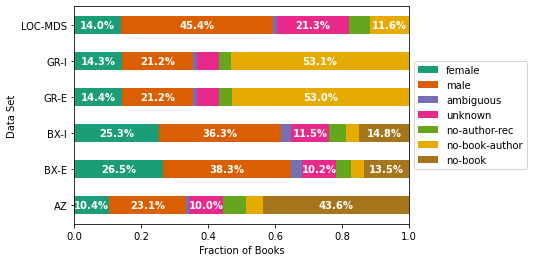

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.104382,0.230610,0.009158,0.100462,0.555387
BX-E,0.264803,0.382913,0.032901,0.102437,0.216947
BX-I,0.253451,0.362989,0.030298,0.114647,0.238616
GR-E,0.143838,0.212356,0.010551,0.066968,0.566288
GR-I,0.143146,0.211894,0.010507,0.067152,0.567301
LOC-MDS,0.139750,0.454321,0.012888,0.212970,0.180071


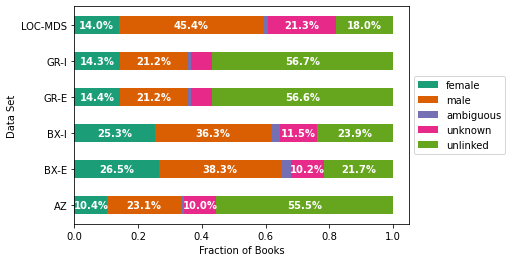

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

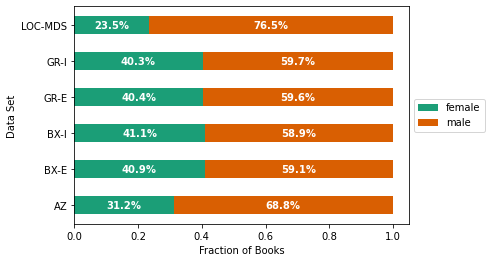

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.211017,0.304050,0.034431,0.091022,0.044105,0.056986,0.258389
BX-E,0.333612,0.424610,0.092337,0.057831,0.019754,0.017823,0.054034
BX-I,0.355283,0.407788,0.087376,0.061925,0.019736,0.018083,0.049809
GR-E,0.368684,0.337102,0.123093,0.036439,0.010765,0.123917,NaN
GR-I,0.376945,0.318826,0.091166,0.045934,0.015568,0.151561,NaN


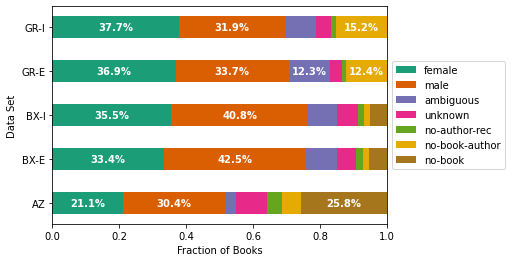

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.211017,0.304050,0.034431,0.091022,0.359481
BX-E,0.333612,0.424610,0.092337,0.057831,0.091611
BX-I,0.355283,0.407788,0.087376,0.061925,0.087628
GR-E,0.368684,0.337102,0.123093,0.036439,0.134682
GR-I,0.376945,0.318826,0.091166,0.045934,0.167129


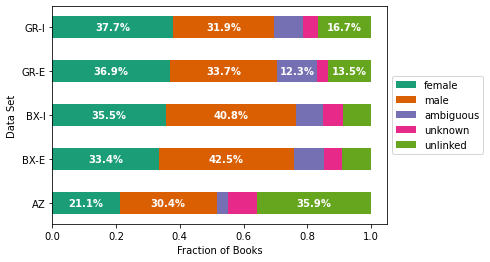

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

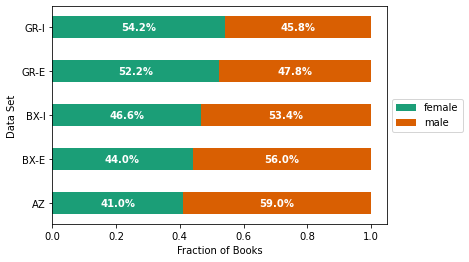

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.344151
BX-E       0.680617
BX-I       0.646738
GR-E       0.366744
GR-I       0.365547
LOC-MDS    0.606960
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')